# Class & Module Imports

In [1]:
# - Module WAXS Classes
from WAXSReduce import WAXSReduce
from WAXSReduce import ImageInterpolator
from WAXSReduce import Integration1D
from WAXSTransform import WAXSTransform
from WAXSDiffSim import WAXSDiffSim
from WAXSSearch import WAXSSearch
# from WAXSExperiment import WAXSExperiment

# - Import Relevant Modules
import xarray as xr
import numpy as np
import pathlib

## Testing Cells

#### Setup DataPaths & Metadata Keys Example

In [2]:
# -- Core Path Definitions -- #
basePath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples')
calibPath = basePath.joinpath('calib_files/ponimask')
dataPath = basePath.joinpath('data_files')

# -- Project Specific Paths -- #
# - March 2023 @ 11-BM (CMS)
poniPath = calibPath.joinpath('may23/may23_poni4_nslsiimar23_12p7keV_CeO_KWPos_mask5_fit2.poni')
maskPath = calibPath.joinpath('may23/may23_nslsiimar23_12p7keV_AgBh_KWPos_wSi_th0p3_mask_5.edf')
zarrPath = basePath.joinpath('output_files/zarr_files')

# - June 2023 @ 11-BM (CMS)
# poniPath = calibPath.joinpath('jun23/jun23_poni_01_LaB6_5.6m_12.7keV_corrected_1150.1s_x-1.601_th0.500_5.00s_1116949_maxs.poni')
# maskPath = calibPath.joinpath('jun23/jun23_nslsii11bmcms_WAXS2pil1M_mask_03.edf')

# -- TIFF Path & Corresponding Metadata Keylist -- #
# Look at your filename, each '_' delimiter spaces out two keys. Add one key for each position in the filename.
metadata_keylist = ['samplenum', 
                    'chemistry', 
                    'filter', 
                    'concentration', 
                    'purge_rate', 
                    'substrate', 
                    'solution_volume', 
                    'runnum', 
                    'clocktime', 
                    'xpos', 
                    'thpos', 
                    'exptime', 
                    'scanID', 
                    'framenum', 
                    'detext']

tiffPath = dataPath.joinpath('sam22_1MAI1PbI2_unfilt_0p3M_5p0scfh_Si_30uL_043_2068.2s_x0.015_th0.300_0.49s_986546_001639_maxs.tiff')
# tiffPath = dataPath.joinpath('/Users/keithwhite/github_repositories/pyWAXS/examples/data_files/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046_1749.9s_x0.017_th0.300_0.49s_986653_001639_maxs.tiff')

#### Create a WAXSReduce Project Instance Example

In [3]:
# - WAXSReduce Class Instantiation
waxs_analysis = WAXSReduce(poniPath=poniPath, 
        maskPath=maskPath, 
        tiffPath=tiffPath, 
        metadata_keylist=metadata_keylist,
        energy = 12.7)


### Generalized Analysis Flow

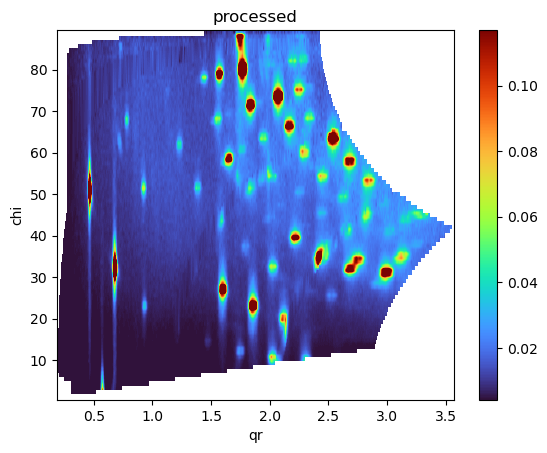

In [4]:
# Caked Image Sin-Chi Correction
cakedtiff_sinchi_xr = waxs_analysis.sinchi_corr(chicorr = True, 
                                                qsqr = True)

# Image Normalization
cakedtiff_xr_norm, (max_x, max_y) = waxs_analysis.normalize_image(img = waxs_analysis.cakedtiff_sinchi_xr, 
                                                  normalizerecip=False)
original_data = cakedtiff_xr_norm

# Image Folding
folded_data = waxs_analysis.fold_image(original_data, 'chi')

# Image Interpolation
data = folded_data
interpolator = ImageInterpolator()
data = interpolator.simple_interpolate(data, 'horizontal', 'slinear')
data = interpolator.simple_interpolate(data, 'vertical', 'slinear')

# Display Image
waxs_analysis.display_image(data, 
                            title='processed', 
                            cmap='turbo')

#### Peak Finding

Number of initial peaks: 2744
Number of recentered peaks: 892
Number of final peaks: 174


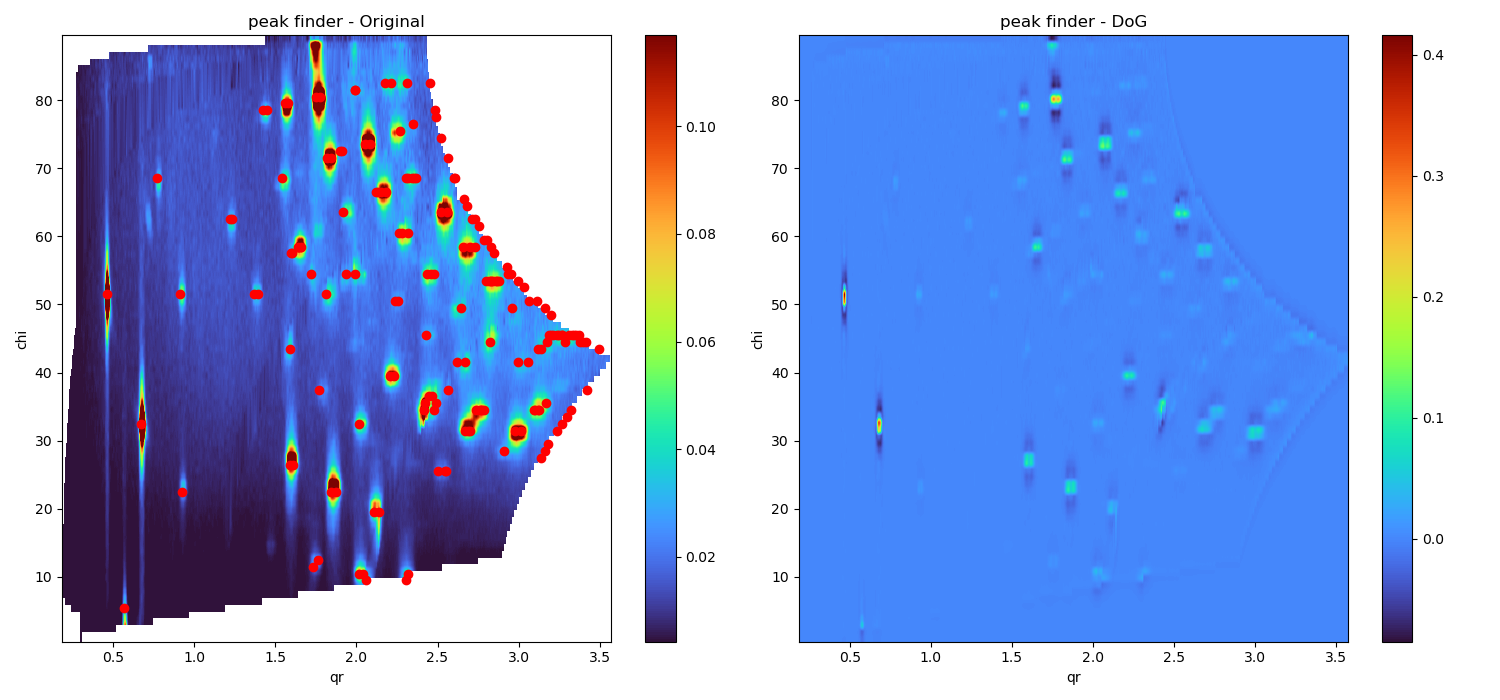

In [5]:
from WAXSSearch import WAXSSearch

%matplotlib widget

# Find peaks (implement the actual peak-finding logic in the find_peaks method)
peak_finder = WAXSSearch()

data = peak_finder.waxssearch_main(data, 
                                     sigma1=.4, 
                                     sigma2=1.5, 
                                     threshold=0.005, 
                                     clustering_method='HDBSCAN', 
                                     eps=1, 
                                     min_samples=2, 
                                     k=6, 
                                     radius=8)

# Display image with peaks
peak_finder.display_image_with_peaks_and_DoG(data,
                                       title='peak finder', 
                                       cmap='turbo')

### 1D Integration Methods

### Define your instance of the Integration1D subclass.
Essentially, you can keep doing as many different integrations as you want on the same origin 'waxs_analysis' dataset and storing the data locally if you keep initializing new integrators. 

The beauty of this is that you can keep recalling your already integrated data as long as you don't overwrite it for that instance.

In [12]:
integrator = Integration1D(waxs_analysis)

Now your integrator object 'integrator' has access to and references your active 'waxs_analysis' session. 

It also has access to all of the WAXSReduce() methods. You can prove it to yourself like this:

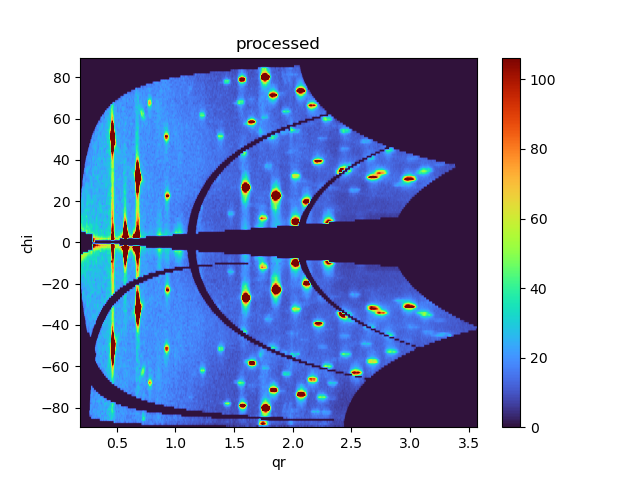

In [13]:
integrator.display_image(integrator.cakedtiff_xr, # Display the caked data we will manipulate with the 1D image processing.
                            title='processed', 
                            cmap='turbo')

#### Cake Slice 1D

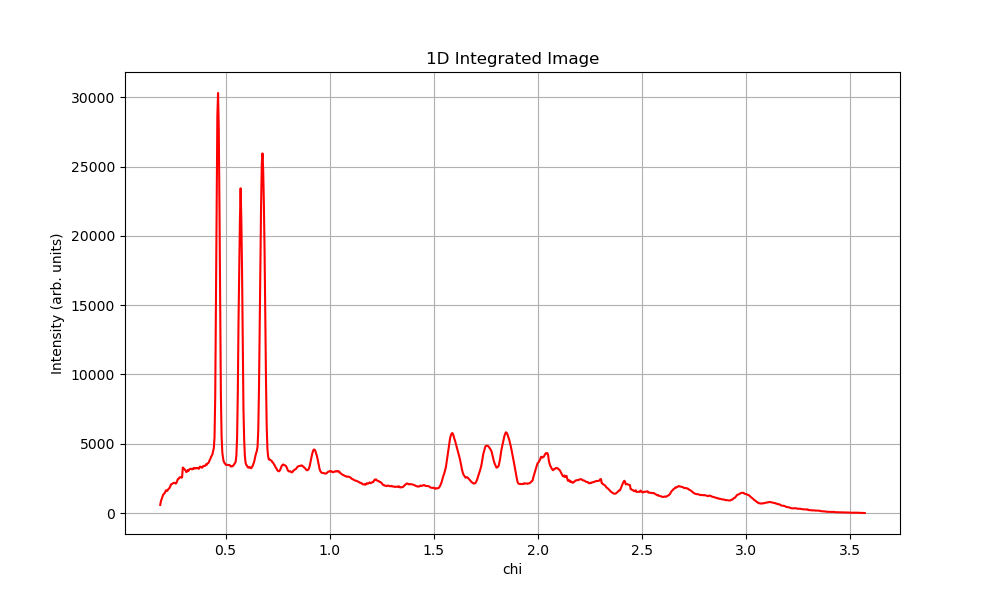

In [14]:
integrator.cakeslice1D(integrator.cakedtiff_xr, chislice=[-90, 90], qrslice=[0, 4], cakeslicesum='chi')

integrator.display_image1D(integrator.cakeslice1D_xr, color='red')

#### Display 2D Recip Space Map

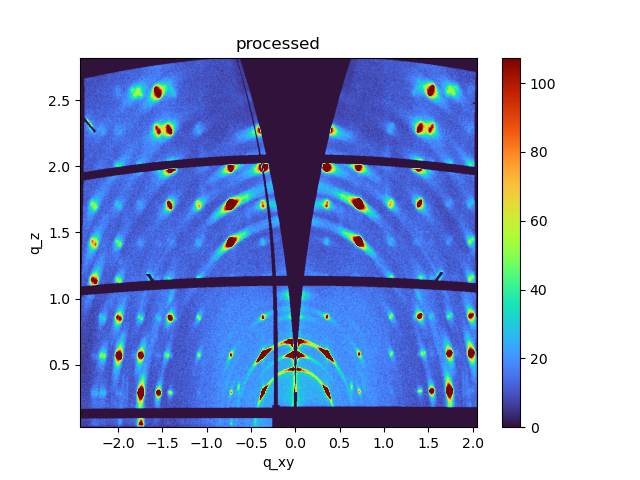

In [15]:
integrator.display_image(integrator.reciptiff_xr, # Display the caked data we will manipulate with the 1D image processing.
                            title='processed', 
                            cmap='turbo')

#### Box Cut 1D

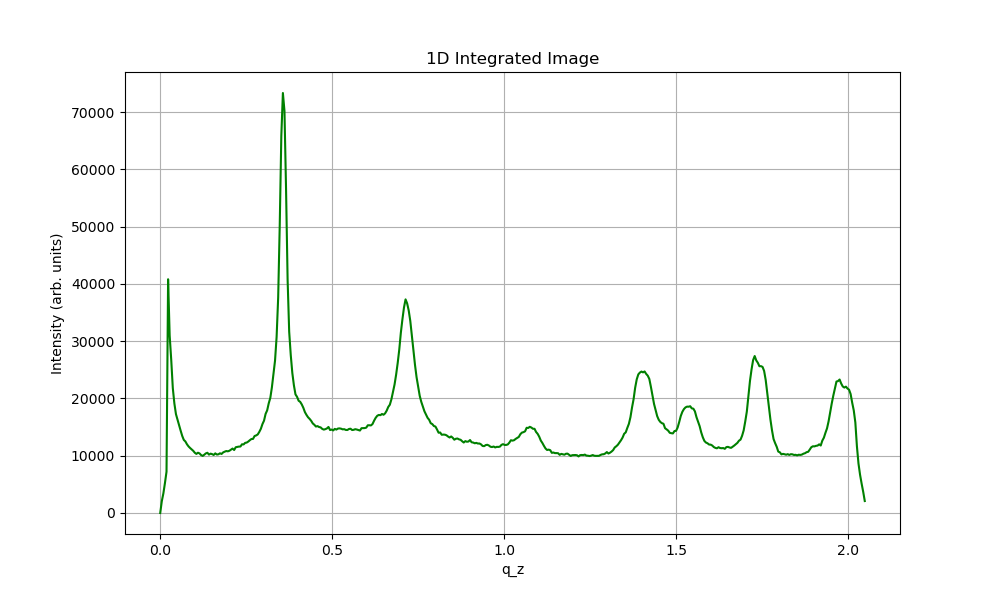

In [19]:
integrator.boxcut1D(integrator.reciptiff_xr, qxyslice=[0, 2.5], qzslice=[0, 2.5], boxcutsum='qz')

integrator.display_image1D(integrator.boxcut1D_xr, color='green')

#### Pole Figure 1D

In [21]:
integrator.polefig1D(integrator.cakedtiff_xr, pole_chislice=[-90, 90], pole_qrslice=[0, 4], poleleveler='linear')

integrator.display_image1D(integrator.boxcut1D_xr, color='green')

<xarray.DataArray (chi: 180)>
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.18792963e+02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.85183927e+02,
       2.95167718e+03, 8.98250441e+03, 1.48438512e+04, 7.60851825e+03,
       2.37495291e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.46348848e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.52016083e+02, 1.27404254e+03, 2.58613735e+03, 1.16053489e+03,
       1.50185822e+03, 2.80257608e+03, 6.53556347e+03, 8.62141023e+03,
       1.33018078e+04, 2.37382288e+04, 1.55812747e+04, 6.19354729e+03,
       2.85811085e+03, 2.64142441e+03, 5.56350946e+03, 3.89246950e+03,
       1.47317564e+03, 1.86723334e+03, 6.07808011e+03, 3.84119640e+03,
       7.86589068e+02, 7.60576457e+02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.39343737e+02, 1.72035261e+03, 3.83593570e+03,
...
       4.57519627e+03, 2.48301374e+03, 6.92323395e+02, 4.44680108e+01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.71717458e+02, 2.46069606e+03, 2.48626939e+03, 3.69627826e+03,
       8.41445901e+03, 5.07442687e+03, 3.35932246e+03, 4.71295438e+03,
       8.01329333e+03, 5.63066353e+03, 4.30544975e+03, 6.49304847e+03,
       1.39763132e+04, 2.55497186e+04, 1.83857626e+04, 1.02084472e+04,
       8.24220807e+03, 5.04483999e+03, 3.07383519e+03, 2.63578743e+03,
       2.80514200e+03, 3.30036182e+03, 1.19588339e+03, 2.85275072e+02,
       4.28933205e+01, 1.37166474e+01, 1.18573572e+01, 0.00000000e+00,
       0.00000000e+00, 2.71475776e+02, 2.39998660e+03, 6.68688024e+03,
       1.47712504e+04, 1.09210757e+04, 3.46453186e+03, 1.40733371e+03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])
Coordinates:
  * chi      (chi) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    pole_chislice:  [-90, 90]
    pole_qrslice:   [0, 4]
    poleleveler:    linear

#### Displaying the 1D data

In [ ]:
integrator.display_image1D(cake_data, color='red')

#### Display the caked data we will manipulate with the 1D image processing.

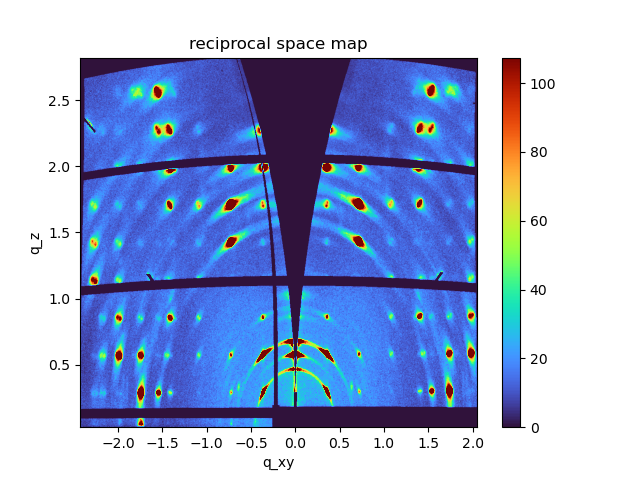

In [10]:
waxs_analysis.display_image(waxs_analysis.reciptiff_xr, 
                            title='reciprocal space map', 
                            cmap='turbo')

# pyWAXS Notebook Tutorial
### WAXSReduce Project Example
#### How to create a new project for WAXS data analysis using the WAXSReduce class:

### (1) Create a WAXSReduce Project Instance Example
#### WAXSReduce is the class name. waxs_analysis is this instance, or single instantiation, of the class. You can change this name 'waxs_analysis' to whatever you want, but you have to use that throughout when trying to reference that instance.

#### (a) Setup DataPaths & Metadata Keys Example

In [ ]:
# -- Core Path Definitions -- #
basePath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples')
calibPath = basePath.joinpath('calib_files/ponimask')
dataPath = basePath.joinpath('data_files')

# -- Project Specific Paths -- #
# - March 2023 @ 11-BM (CMS)
poniPath = calibPath.joinpath('may23/may23_poni4_nslsiimar23_12p7keV_CeO_KWPos_mask5_fit2.poni')
maskPath = calibPath.joinpath('may23/may23_nslsiimar23_12p7keV_AgBh_KWPos_wSi_th0p3_mask_5.edf')
zarrPath = basePath.joinpath('output_files/zarr_files')

# -- TIFF Path & Corresponding Metadata Keylist -- #
# Look at your filename, each '_' delimiter spaces out two keys. Add one key for each position in the filename.
metadata_keylist = ['samplenum', 
                    'chemistry', 
                    'filter', 
                    'concentration', 
                    'purge_rate', 
                    'substrate', 
                    'solution_volume', 
                    'runnum', 
                    'clocktime', 
                    'xpos', 
                    'thpos', 
                    'exptime', 
                    'scanID', 
                    'framenum', 
                    'detext']

tiffPath = dataPath.joinpath('sam22_1MAI1PbI2_unfilt_0p3M_5p0scfh_Si_30uL_043_2068.2s_x0.015_th0.300_0.49s_986546_001639_maxs.tiff')


#### (b) Create Project Session

In [ ]:
# - WAXSReduce Class Instantiation
waxs_analysis = WAXSReduce(poniPath=poniPath, 
        maskPath=maskPath, 
        tiffPath=tiffPath, 
        metadata_keylist=metadata_keylist,
        energy = 12.7)

##### Notice how we loaded all of the following: image correction file references, the X-ray energy, and the data?

Assuming your file has the incidence angle in the sample name, we can generate accurately corrected images. You can now access the reciprocal space image corrections and caked image corrections:

Reciprocal Space Map:
```python
waxs_analysis.reciptiff_xr
```

Caked Image:
```python
waxs_analysis.cakedtiff_xr
```

In [ ]:
waxs_analysis.reciptiff_xr

##### Note how we had to use the syntax:
```python
waxs_analysis.
```
##### to access the the data.
This is how we access the instance that refers to your analysis project. You can have multiple instances coexist in the same notebook.

Now, click the 'Attributes' dropdown above. We loaded the data into an XArray DataArray (DA). 
##### All of the keys listed above in the setup were used to extract your metadata from the filename.

### (2) Image Plotting Examples

#### (a) Display Image (Generalized Plotting)

In [ ]:
%matplotlib widget

# -- Display the Caked Image
# waxs_analysis.cakeddisplay_xr() # method 1

# waxs_analysis.display_image(waxs_analysis.cakedtiff_xr, # method 2
waxs_analysis.display_image(waxs_analysis.cakedtiff_xr, 
                            title='caked image', 
                            cmap='turbo')

##### You can plot the data stored as attributes with one of a set of built-in methods, or a generalized method.

Custom Method (Caked Image):
```python
waxs_analysis.cakeddisplay_xr()
```
General Method Equivalent:
```python
waxs_analysis.display_image(waxs_analysis.cakedtiff_xr, 
                            title='Caked Image', 
                            cmap='turbo')
```

#### (b) Quick Plotting Methods

##### (i) Raw Data

In [ ]:
%matplotlib widget
waxs_analysis.rawdisplay_xr()
# waxs_analysis.rawtiff_xr

##### (ii) Reciprocal Space Map

In [ ]:
%matplotlib widget
waxs_analysis.recipdisplay_xr()
# waxs_analysis.reciptiff_xr

##### (iii) Caked Image

In [ ]:
%matplotlib widget
waxs_analysis.cakeddisplay_xr()
# waxs_analysis.cakedtiff_xr

### (3) 2D Image Processing Examples

#### (a) Image Intensity Correction (sin(chi)) Example

In [ ]:
%matplotlib widget

cakedtiff_sinchi_xr = waxs_analysis.sinchi_corr(chicorr = True, 
                                                qsqr = True)

waxs_analysis.display_image(waxs_analysis.cakedtiff_sinchi_xr, 
                            title='caked image, sin(chi) corrected', 
                            cmap='turbo')

#### (b) Image Normalization Example

In [ ]:
%matplotlib widget

# Generate the normalized reciprocal space map image
cakedtiff_xr_norm, (max_x, max_y) = waxs_analysis.normalize_image(img = waxs_analysis.cakedtiff_sinchi_xr, 
                                                  normalizerecip=False)

# Check if the returned image is None or not of a compatible type
if cakedtiff_xr_norm is None or not isinstance(cakedtiff_xr_norm, (np.ndarray, xr.DataArray)):
    raise ValueError("The normalized image is None or not of a compatible type.")

print ('Maximum Intensity Pixel Coordinate: ', 'x: ', max_x, 'y: ', max_y)

# Display the normalized image
waxs_analysis.display_image(cakedtiff_xr_norm, 
                            title='caked, sin(chi) corrected, normalized', 
                            cmap='turbo')


#### (c) Image Folding Example

In [ ]:
# Create a WAXS_Analyze instance and test the fold_image method
# waxs = WAXS_Analyze()
# original_data = .cakedtiff_xr.copy()
# folded_data = waxs.fold_image(waxs.cakedtiff_xr, 'chi')

original_data = cakedtiff_xr_norm
# original_data = waxs_analysis.cakedtiff_xr
folded_data = waxs_analysis.fold_image(original_data, 'chi')

# Display the original and folded data for validation
# original_data, folded_data

waxs_analysis.display_image(folded_data, 
                            title='caked, sin(chi) corrected, normalized, folded', 
                            cmap='turbo')

#### (d) Image Interpolation Example

In [ ]:
import matplotlib.pyplot as plt

%matplotlib widget

data = folded_data

interpolator = ImageInterpolator()
data = interpolator.simple_interpolate(data, 'horizontal', 'slinear')
data = interpolator.simple_interpolate(data, 'vertical', 'slinear')
# data = interpolator.patch_interpolate(data)

# interpolator.save_dataarray_to_netcdf(interpolated_img, 'test_file')

waxs_analysis.display_image(data, 
                            title='interpolated', 
                            cmap='turbo')

''' # -- Testing Different Interpolation Algorithms
# interpolated_img = interpolator.patch_interpolate(data)
# interp_horizontal = interpolator.linear_interpolate(data, 'horizontal')
# interp_vertical = interpolator.linear_interpolate(data, 'vertical')
# interpolated = interpolator.simple_interpolate(data, 'vertical', 'linear')

# # Create an instance of the ImageInterpolator class
# interpolator = ImageInterpolator()

# # Define methods and directions
# # methods = ["linear", "nearest", "zero", "slinear", "quadratic", "cubic",
# #            "polynomial", "barycentric", "krog", "pchip", "spline", "akima"]
# methods = ["linear", "nearest", "zero", "slinear", "akima"]
# directions = ["vertical", "horizontal"]

# # Let's visualize all the interpolated results to understand how each method performs.

# # Dictionary to store the results
# interpolated_results = {}

# # Iterate through all combinations of methods and directions to perform interpolation
# for method in methods:
#     for direction in directions:
#         try:
#             interpolated_img = interpolator.simple_interpolate(data.copy(), direction, method)
#             key = f"{method}_{direction}"
#             interpolated_results[key] = interpolated_img
#         except Exception as e:
#             print(f"Skipped {method} in {direction} direction due to error: {e}")

# # Let's visualize all the interpolated results to understand how each method performs.
# fig, axes = plt.subplots(len(methods), len(directions), figsize=(20, 40))
# axes = axes.flatten()

# for i, (key, data) in enumerate(interpolated_results.items()):
#     ax = axes[i]
#     data.plot(ax=ax, add_colorbar=False, cmap='turbo')
#     ax.set_title(f"Method: {key}")

# plt.tight_layout()
# plt.show()
'''

#### (e) Image Smoothing Example

In [ ]:
%matplotlib widget
# import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm
# cmap = plt.cm.turbo
# cmap.set_bad('black')

waxs_analysis.smooth_image(folded_data, method='gaussian', sigma=1e-6)

smoothed_image, (max_x, max_y) = waxs_analysis.normalize_image(img = waxs_analysis.smoothed_img, normalizerecip=False)

print ('Maximum Intensity Pixel Coordinate: ', 'x: ', max_x, 'y: ', max_y)

# Display the smoothed image with appropriate coordinates using the 'display_image' method
# plt = waxs_analysis.display_image(waxs_analysis.smoothed_img, 
waxs_analysis.display_image(waxs_analysis.smoothed_img, 
                            title='caked, sin(chi) corrected, normalized, folded, smoothed', 
                            cmap='turbo')


#### (f) 2D Image Peak Finding Example

In [ ]:
%matplotlib widget

data = None
data = folded_data
# Find peaks (implement the actual peak-finding logic in the find_peaks method)

data = waxs_analysis.find_peaks_DoG (data, 
                                     sigma1=.4, 
                                     sigma2=2, 
                                     threshold=0.008, 
                                     clustering_method='HDBSCAN', 
                                     eps=1, 
                                     min_samples=2, 
                                     k=3, 
                                     radius=5)

# Display image with peaks
waxs_analysis.display_image_with_peaks_and_DoG(data,
                                       title='peak finder', 
                                       cmap='turbo')

### (4) 1D Data Reduction (Integration)

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
cmap = plt.cm.turbo
cmap.set_bad('black')
plt.close('all')

# DA = waxs_analysis.cakedtiff_xr
# DA = cakedtiff_sinchi_xr
DA = waxs_analysis.smoothed_img
# DA, (max_x, max_y) = waxs_analysis.normalize_image(img = waxs_analysis.cakedtiff_xr, normalizerecip=False)

colors = cmap(np.linspace(0,1,10))
# fig, axs = plt.subplots(1, 2, figsize=(9,3))
# plot.line(ax=axs[0], color=colors[i])

axs = DA.sum('chi').sel(method='nearest').sel(qr=slice(0.2,3)).plot.line(color=colors[9])
plt.show()

### (5) Saving/Exporting & Loading Project Sessions

#### (a) Exporting a Project

In [ ]:
basePath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples')
zarrPath = basePath.joinpath('output_files/zarr_files')
projectName = 'test_project'
waxs_analysis.exportzarr(zarrPath=zarrPath, projectName=projectName)

#### (b) Load an Existing Project

In [ ]:
basePath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples')
zarrPath = basePath.joinpath('output_files/zarr_files')
projectName = 'test_project'
waxs_analysis = WAXSReduce(zarrPath = zarrPath, projectName = projectName)

## Additional Examples

#### Normalize Image (Reciprocal Space Map)

In [ ]:
%matplotlib widget

# Generate the normalized reciprocal space map image
reciptiff_xr_norm = waxs_analysis.normalize_image()

# Check if the returned image is None or not of a compatible type
if reciptiff_xr_norm is None or not isinstance(reciptiff_xr_norm, (np.ndarray, xr.DataArray)):
    raise ValueError("The normalized image is None or not of a compatible type.")

# Display the normalized image
waxs_analysis.display_image(reciptiff_xr_norm, 
                            title='Normalized Image', 
                            cmap='jet')


In [ ]:
reciptiff_xr_norm

#### Normalize Image (Reciprocal Space Map)

In [ ]:
%matplotlib widget

# Generate the normalized reciprocal space map image
reciptiff_xr_norm = waxs_analysis.normalize_image()

# Check if the returned image is None or not of a compatible type
if reciptiff_xr_norm is None or not isinstance(reciptiff_xr_norm, (np.ndarray, xr.DataArray)):
    raise ValueError("The normalized image is None or not of a compatible type.")

# Display the normalized image
waxs_analysis.display_image(reciptiff_xr_norm, 
                            title='Normalized Image', 
                            cmap='jet')


#### Interpolate Image

In [ ]:
%matplotlib widget

cakedtiff_xr_interp = waxs_analysis.brute_force_interpolate(waxs_analysis.cakedtiff_xr, gap_threshold = 12)

# Display the normalized image
waxs_analysis.display_image(cakedtiff_xr_interp, 
                            title='Interpolated Image', 
                            cmap='jet')

# What about alternating row/column with linearly increasing gap_threshold size?
# Or a row/column average process?

#### Normalize Image

In [ ]:
%matplotlib widget

# Generate the normalized reciprocal space map image
reciptiff_xr_norm = waxs_analysis.normalize_image()

# Check if the returned image is None or not of a compatible type
if reciptiff_xr_norm is None or not isinstance(reciptiff_xr_norm, (np.ndarray, xr.DataArray)):
    raise ValueError("The normalized image is None or not of a compatible type.")

# Display the normalized image
waxs_analysis.display_image(reciptiff_xr_norm, 
                            title='Normalized Image', 
                            cmap='jet')


In [ ]:
%matplotlib widget

# Handle edge detection
edge_img = waxs_analysis.edge_detection(waxs_analysis.reciptiff_xr, method='canny')  # or 'canny'

# Classify the gaps
gaps = waxs_analysis.classify_gaps(edge_img, tolerance = 20, padding = 1)

# Interpolate gaps
reciptiff_xr_interp = waxs_analysis.interpolate_gaps(waxs_analysis.reciptiff_xr, gaps, threshold=0.1)

# Alternatively, you can use handle_interpolation for a one-step approach
# reciptiff_xr_interp = waxs_analysis.handle_interpolation(method='sobel')

# Display the normalized image
waxs_analysis.display_image(reciptiff_xr_interp, 
                            title='Interpolated Image', 
                            cmap='jet')

In [ ]:
edge_img = waxs_analysis.edge_detection(waxs_analysis.reciptiff_xr, method='canny')  # or 'canny'

# gaps

waxs_analysis.display_image(edge_img, 
                            title='Interpolated Image', 
                            cmap='jet')

# Define coordinates for plotting based on the original image
# coords = {
#     'x_min': waxs_analysis.reciptiff_xr[waxs_analysis.inplane_config].min(),
#     'x_max': waxs_analysis.reciptiff_xr[waxs_analysis.inplane_config].max(),
#     'y_min': waxs_analysis.reciptiff_xr['q_z'].min(),
#     'y_max': waxs_analysis.reciptiff_xr['q_z'].max()
# }

#### Smoothing Image

In [ ]:
%matplotlib widget

# Smooth the image using the 'smooth_image' method
# smoothed_image = waxs_analysis.smooth_image(waxs_analysis.reciptiff_xr.values, 
#                                             method='gaussian', 
#                                             sigma=.05)

smoothed_image = waxs_analysis.smooth_image(waxs_analysis.reciptiff_xr, 
                                            method='gaussian', 
                                            sigma=1)
# smoothed_image = waxs_analysis.normalize_image()
# smoothed_image = waxs_analysis.smooth_image(smoothed_image, method='total_variation', sigma=100)

# Display the smoothed image with appropriate coordinates using the 'display_image' method
waxs_analysis.display_image(smoothed_image, 
                            title='Smoothed Image', 
                            cmap='jet')


#### Signal-to-Noise Calculation

In [ ]:
smoothed_image = waxs_analysis.calculate_SNR(smoothed_image)
# waxs_analysis.snrtemp
waxs_analysis.reciptiff_xr.SNR

#### Peak Finder

In [ ]:
# Find peaks using the 'find_peaks' method
waxs_analysis.find_peaks()

#### Image Pixel Intensity Binning Example

#### Image Intensity Layering Example

#### Image Layer Peak Search Example

#### Image Layer-Peak Convolution Example